# SAN - Praktische Arbeit (Marvel Universe Social Network)

## Netzwerkanalyse

In [52]:
import os
import sys
import pandas as pd
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite, centrality, community
import matplotlib.pyplot as plt

from helper import *

### Daten einlesen

In [53]:
nodes_df = pd.read_csv('Daten/nodes.csv')
edges_df = pd.read_csv('Daten/edges.csv')
df_heros = pd.read_csv('Daten/hero-network.csv')

### Initiales Netzwerk

Hier erstellen wir ein initiales ungerichtetes Netzwerk mit allen Verbindungen, ohne Filterungen.

In [54]:
heroes_df = nodes_df[nodes_df['type'] == 'hero']

B = nx.Graph()

B.add_nodes_from(heroes_df['node'])
B.add_edges_from(edges_df[['hero', 'comic']].values)
B.name = 'Marvel Universe'

print_network_information(B)

Information for given Graph with name 'Marvel Universe':
	Graph is directed: False
	Number of nodes: 19091
	Number of edges: 96104


In [55]:
heroes_df['node']

3        24-HOUR MAN/EMMANUEL
4        3-D MAN/CHARLES CHAN
5            4-D MAN/MERCURIO
6                     8-BALL/
534              ABBOTT, JACK
                 ...         
19085             ZOTA, CARLO
19086                    ZOTA
19087                   ZURAS
19088                    ZURI
19089                   ZZZAX
Name: node, Length: 6439, dtype: object

In diesem Netzwerk gibt es keine direkten Verbindungen zwischen Helden oder zwischen Comics untereinander. Stattdessen sind die Helden mit Comics verbunden, was anzeigt, in welchen Comics die jeweiligen Helden erscheinen. Diese Struktur ist typisch für bipartite Netzwerke, in denen die beiden Knotentypen unterschiedliche Entitäten darstellen (in diesem Fall Helden und Comics) und die Kanten die Beziehungen zwischen diesen Entitäten repräsentieren.

### One-Mode-Netzwerk

Da das Netzwerk sehr gross ist, würden die Berechnungen und Darstellungen sehr lange dauern. Deshalb haben wir uns entschieden, das Netzwerk in ein One-Mode-Netzwerk umzuwandeln, in dem die Helden direkt miteinander verbunden sind, wenn sie in mindestens einem Comic gemeinsam auftreten. Dieses Netzwerk ist zwar nicht mehr bipartit, aber es enthält alle relevanten Informationen, die wir für die Analyse benötigen.

Dazu werden wir auch nur die 100 am häufigsten vorkommenden Helden berücksichtigen, um die Berechnungen zu beschleunigen. 

In [56]:
top_heroes = edges_df['hero'].value_counts().head(100).index.tolist()
top_heroes[:5]

['SPIDER-MAN/PETER PARKER',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'THOR/DR. DONALD BLAK']

## Frage 1 - Welche Helden sind die zentralsten im Netzwerk?

Um die Frage zu beantworten, welche Helden die zentralsten im Netzwerk sind, werden wir die drei genannten Zentralitätsmaße verwenden: Degree-Centrality, Betweenness-Centrality und Closeness-Centrality. Diese Maße geben jeweils unterschiedliche Aspekte der Zentralität eines Knotens im Netzwerk an:
- Degree-Centrality misst die Anzahl der direkten Verbindungen, die ein Knoten hat. Für Helden in unserem Netzwerk bedeutet ein hoher Wert, dass sie in vielen verschiedenen Comics erscheinen.
- Betweenness-Centrality gibt an, wie oft ein Knoten auf den kürzesten Pfaden zwischen anderen Knoten liegt. Ein hoher Wert deutet darauf hin, dass der Held eine wichtige Rolle in der Verbindung verschiedener Teile des Netzwerks spielt.
- Closeness-Centrality misst, wie nahe ein Knoten im Durchschnitt zu allen anderen Knoten im Netzwerk liegt. Ein hoher Wert zeigt an, dass ein Held im Durchschnitt schneller mit anderen Knoten verbunden werden kann.

Da das Netzwerk bipartit ist, muss beachtet werden, dass Closeness-Centrality für große Netzwerke möglicherweise nicht gut definiert ist, da nicht alle Knoten miteinander verbunden sind (Helden sind nur mit Comics verbunden, nicht direkt mit anderen Helden). Trotzdem führen wir die Analyse für alle drei Maße durch.

### Ganzes Netzwerk

In [57]:
B = nx.Graph()
B.add_nodes_from(nodes_df[nodes_df['type'] == 'hero']['node'], bipartite=0, type='hero')
B.add_nodes_from(nodes_df[nodes_df['type'] == 'comic']['node'], bipartite=1, type='comic')
B.add_edges_from(edges_df.values)

# Calculate degree centrality
degree_centrality = nx.degree_centrality(B)

# Sort the dictionary by degree centrality
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a dictionary
top_degree_centrality_dict = {hero: centrality for hero, centrality in top_degree_centrality}

for hero, centrality in top_degree_centrality_dict.items():
    print(f"{hero} hat eine Degree-Zentralität von {centrality:.3f}")

SPIDER-MAN/PETER PARKER hat eine Degree-Zentralität von 0.083
CAPTAIN AMERICA hat eine Degree-Zentralität von 0.070
IRON MAN/TONY STARK hat eine Degree-Zentralität von 0.060
THING/BENJAMIN J. GR hat eine Degree-Zentralität von 0.050
THOR/DR. DONALD BLAK hat eine Degree-Zentralität von 0.050
HUMAN TORCH/JOHNNY S hat eine Degree-Zentralität von 0.046
MR. FANTASTIC/REED R hat eine Degree-Zentralität von 0.045
HULK/DR. ROBERT BRUC hat eine Degree-Zentralität von 0.044
WOLVERINE/LOGAN hat eine Degree-Zentralität von 0.043
INVISIBLE WOMAN/SUE hat eine Degree-Zentralität von 0.040


### Netzwerk mit nur den 100 häufigsten Helden

weil datensatz so riesig ist und die laufzeit so lange ist haben wir nur die top 100 berücksichtigt

In [58]:
# Ermitteln der Top 100 Helden basierend auf der Anzahl der Erscheinungen
top_heroes = edges_df['hero'].value_counts().head(100).index

# Erstellen eines bipartiten Graphen
G = nx.Graph()
G.add_nodes_from(nodes_df['node'])
G.add_edges_from(edges_df[['hero', 'comic']].values)

# Erstellen einer One-Mode-Projektion des Graphen, die nur die Top 100 Helden enthält
top_heroes_subgraph = nx.bipartite.weighted_projected_graph(G, top_heroes)

# Berechnung der Zentralitätsmaße für den One-Mode-Subgraphen
degree_centrality = nx.degree_centrality(top_heroes_subgraph)
betweenness_centrality = nx.betweenness_centrality(top_heroes_subgraph)
closeness_centrality = nx.closeness_centrality(top_heroes_subgraph)

# Sort the dictionaries by centrality
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

top_degree_centrality[:5], top_betweenness_centrality[:5], top_closeness_centrality[:5]

([('CAPTAIN AMERICA', 0.32470389170896785),
  ('SPIDER-MAN/PETER PARKER', 0.2967851099830795),
  ('IRON MAN/TONY STARK', 0.2649746192893401),
  ('THING/BENJAMIN J. GR', 0.24500846023688663),
  ('MR. FANTASTIC/REED R', 0.23959390862944163)],
 [('SPIDER-MAN/PETER PARKER', 0.08742933210238864),
  ('CAPTAIN AMERICA', 0.07111762293161948),
  ('IRON MAN/TONY STARK', 0.046987566678910464),
  ('WOLVERINE/LOGAN', 0.04574329086892057),
  ('HAVOK/ALEX SUMMERS', 0.045018174043208854)],
 [('CAPTAIN AMERICA', 0.5969094030905969),
  ('SPIDER-MAN/PETER PARKER', 0.5863095238095238),
  ('IRON MAN/TONY STARK', 0.5742882130016519),
  ('THING/BENJAMIN J. GR', 0.5698033166216737),
  ('MR. FANTASTIC/REED R', 0.5680507497116494)])

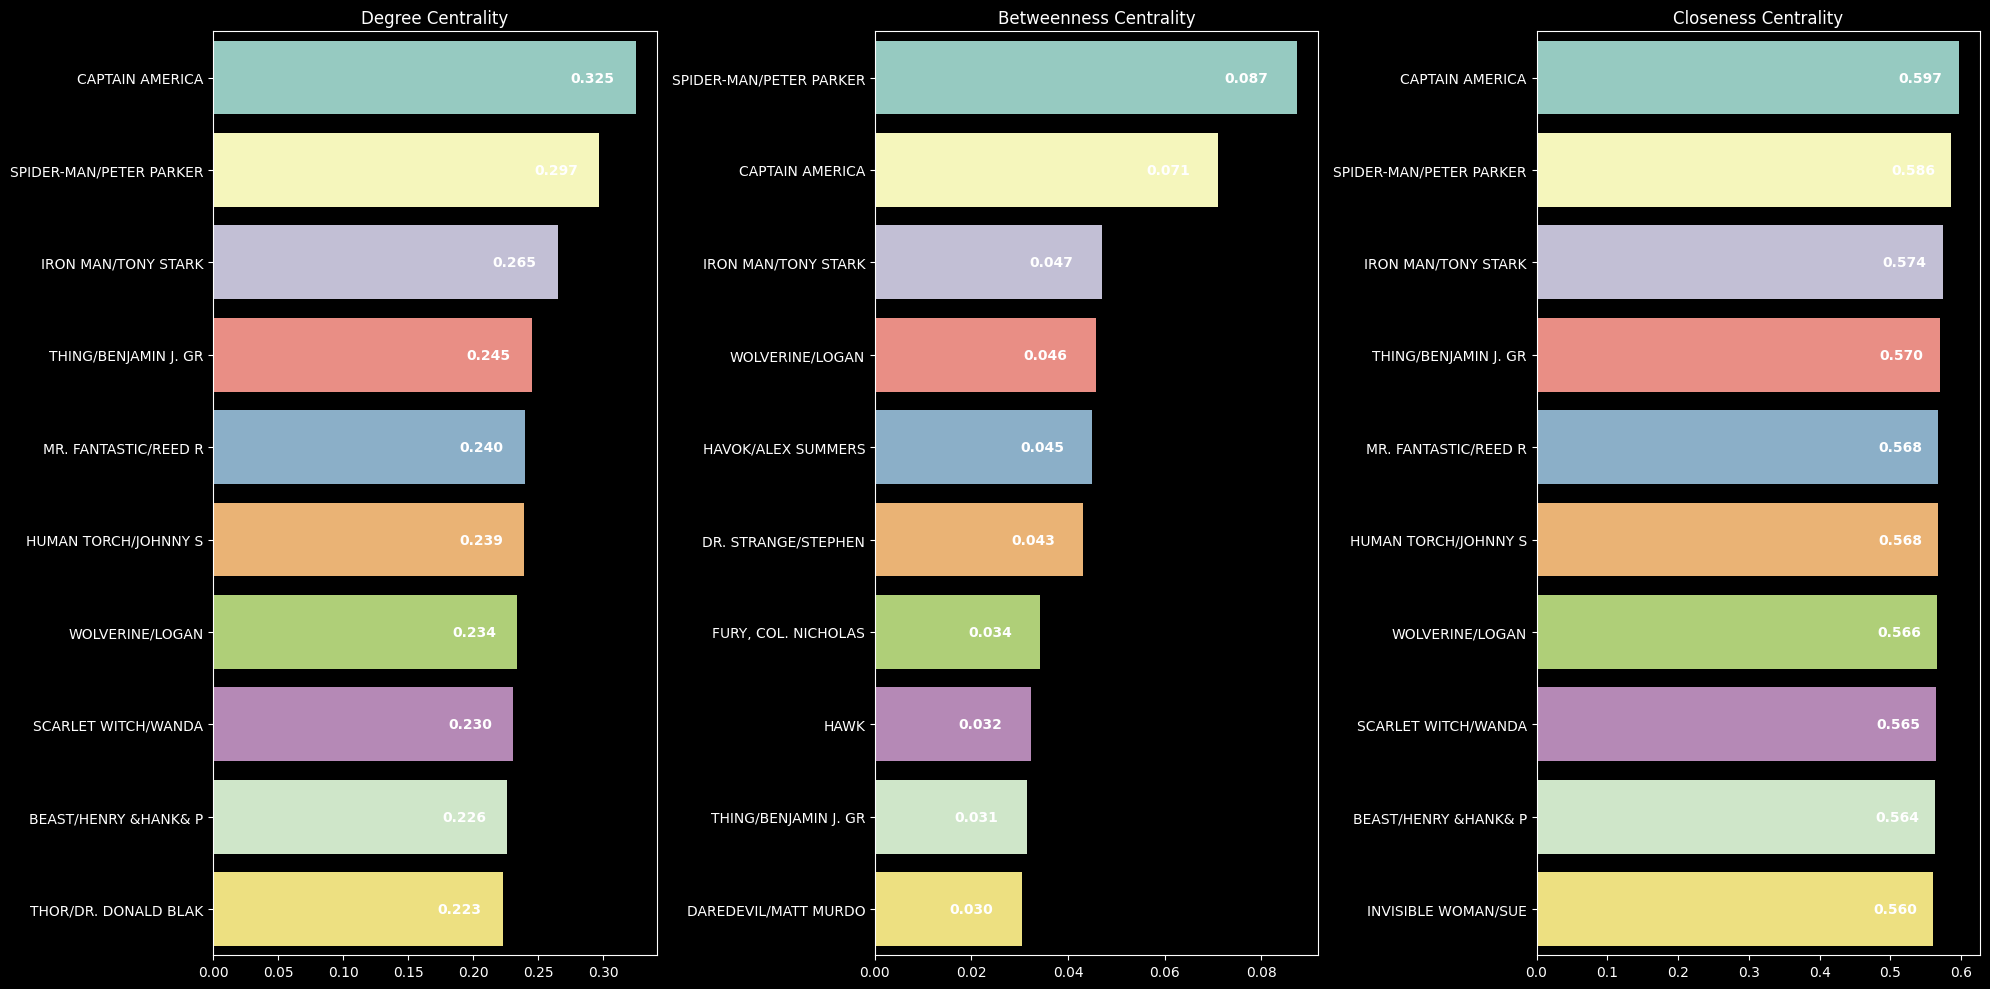

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# Plot the degree centrality distribution
sns.barplot(y=[hero for hero, centrality in top_degree_centrality[:10]],
            x=[centrality for hero, centrality in top_degree_centrality[:10]],
            ax=ax[0])
ax[0].set_title('Degree Centrality')

for i, (hero, centrality) in enumerate(top_degree_centrality[:10]):
    ax[0].text(centrality - 0.05, i, f"{centrality:.3f}", va='center', color='white', fontweight='bold')

# Plot the betweenness centrality distribution
sns.barplot(y=[hero for hero, centrality in top_betweenness_centrality[:10]],
            x=[centrality for hero, centrality in top_betweenness_centrality[:10]],
            ax=ax[1])
ax[1].set_title('Betweenness Centrality')

for i, (hero, centrality) in enumerate(top_betweenness_centrality[:10]):
    ax[1].text(centrality -0.015, i, f"{centrality:.3f}", va='center', color='white', fontweight='bold')

# Plot the closeness centrality distribution
sns.barplot(y=[hero for hero, centrality in top_closeness_centrality[:10]],
            x=[centrality for hero, centrality in top_closeness_centrality[:10]],
            ax=ax[2])
ax[2].set_title('Closeness Centrality')

for i, (hero, centrality) in enumerate(top_closeness_centrality[:10]):
    ax[2].text(centrality -0.085, i, f"{centrality:.3f}", va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

## Frage 2 - Wie ist die Verteilung der Anzahl der Comics pro Held?

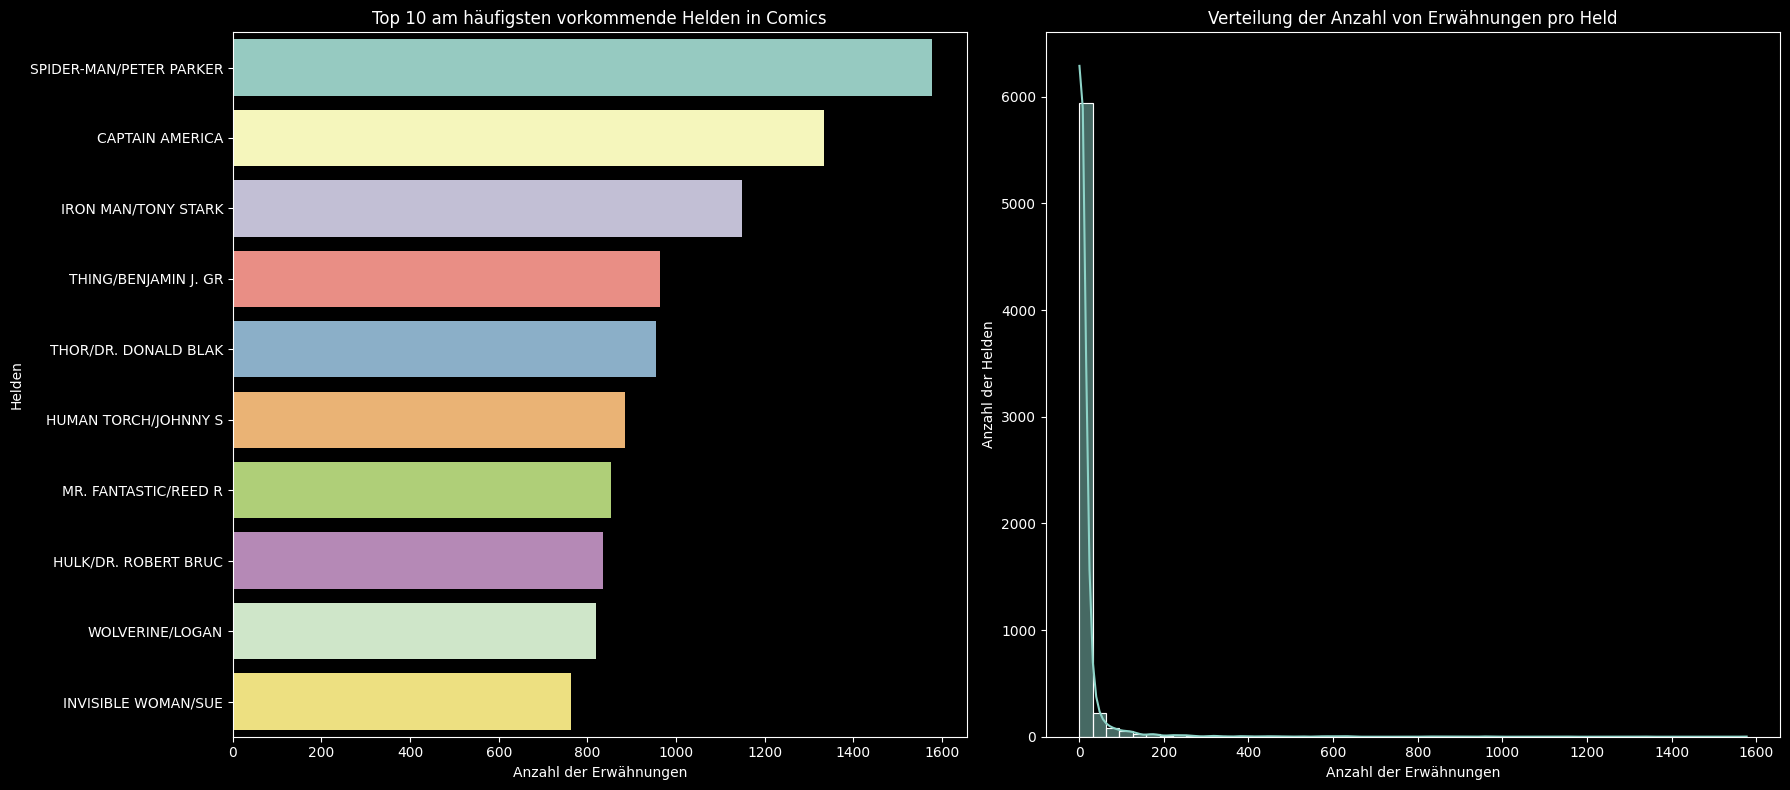

In [60]:
# Count the number of mentions for each hero
hero_mentions = edges_df['hero'].value_counts()
top_heroes = hero_mentions.head(10)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Top 10 most frequent comics
sns.barplot(x=top_heroes.values, y=top_heroes.index, ax=axes[0])
axes[0].set_title('Top 10 am häufigsten vorkommende Helden in Comics')
axes[0].set_xlabel('Anzahl der Erwähnungen')
axes[0].set_ylabel('Helden')

# Distribution plot of mentions per comic
sns.histplot(hero_mentions, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Verteilung der Anzahl von Erwähnungen pro Held')
axes[1].set_xlabel('Anzahl der Erwähnungen')
axes[1].set_ylabel('Anzahl der Helden')

plt.tight_layout()
plt.show()

## Frage 3 - Gibt es Gruppen oder Gemeinschaften von Helden, die häufig zusammen in Comics erscheinen?

### One-mode Projektion

In [61]:
top_edges_df = edges_df[edges_df["hero"].isin(top_heroes.index)]

G = nx.Graph()

# Add nodes with the node attribute "bipartite"
G.add_nodes_from(top_heroes, bipartite=0)  # Heroes
G.add_nodes_from(set(top_edges_df['comic']), bipartite=1)  # Comics

# Add edges with weights based on the number of shared comics
for hero, df in top_edges_df.groupby('hero'):
    for comic in df['comic']:
        if G.has_edge(hero, comic):
            G[hero][comic]['weight'] += 1
        else:
            G.add_edge(hero, comic, weight=1)

In [62]:
# Create a one-mode projection of the graph where nodes are heroes
# and edges represent the number of comics they both appear in
G_one_mode = nx.bipartite.weighted_projected_graph(G, list(top_heroes.index))

# Extract the weights for the edges and sort them to find the strongest connections
weights = nx.get_edge_attributes(G_one_mode, 'weight')
sorted_weights = sorted(weights.items(), key=lambda item: item[1], reverse=True)

# Output the graph edges with weights and the strongest connections
sorted_weights[:10], list(G_one_mode.edges(data=True))[:10]

([(('THING/BENJAMIN J. GR', 'HUMAN TORCH/JOHNNY S'), 724),
  (('HUMAN TORCH/JOHNNY S', 'MR. FANTASTIC/REED R'), 694),
  (('THING/BENJAMIN J. GR', 'MR. FANTASTIC/REED R'), 690),
  (('MR. FANTASTIC/REED R', 'INVISIBLE WOMAN/SUE'), 682),
  (('HUMAN TORCH/JOHNNY S', 'INVISIBLE WOMAN/SUE'), 675),
  (('THING/BENJAMIN J. GR', 'INVISIBLE WOMAN/SUE'), 650),
  (('CAPTAIN AMERICA', 'IRON MAN/TONY STARK'), 440),
  (('CAPTAIN AMERICA', 'THOR/DR. DONALD BLAK'), 380),
  (('IRON MAN/TONY STARK', 'THOR/DR. DONALD BLAK'), 339),
  (('CAPTAIN AMERICA', 'THING/BENJAMIN J. GR'), 170)],
 [('SPIDER-MAN/PETER PARKER', 'THOR/DR. DONALD BLAK', {'weight': 96}),
  ('SPIDER-MAN/PETER PARKER', 'HUMAN TORCH/JOHNNY S', {'weight': 147}),
  ('SPIDER-MAN/PETER PARKER', 'IRON MAN/TONY STARK', {'weight': 95}),
  ('SPIDER-MAN/PETER PARKER', 'WOLVERINE/LOGAN', {'weight': 63}),
  ('SPIDER-MAN/PETER PARKER', 'CAPTAIN AMERICA', {'weight': 145}),
  ('SPIDER-MAN/PETER PARKER', 'INVISIBLE WOMAN/SUE', {'weight': 97}),
  ('SPIDER-MA

Wir sehen hier die stärksten Verbindungen zwischen den einzelnen Helden. Vorallem stark sind die von den Fantastic Four. 

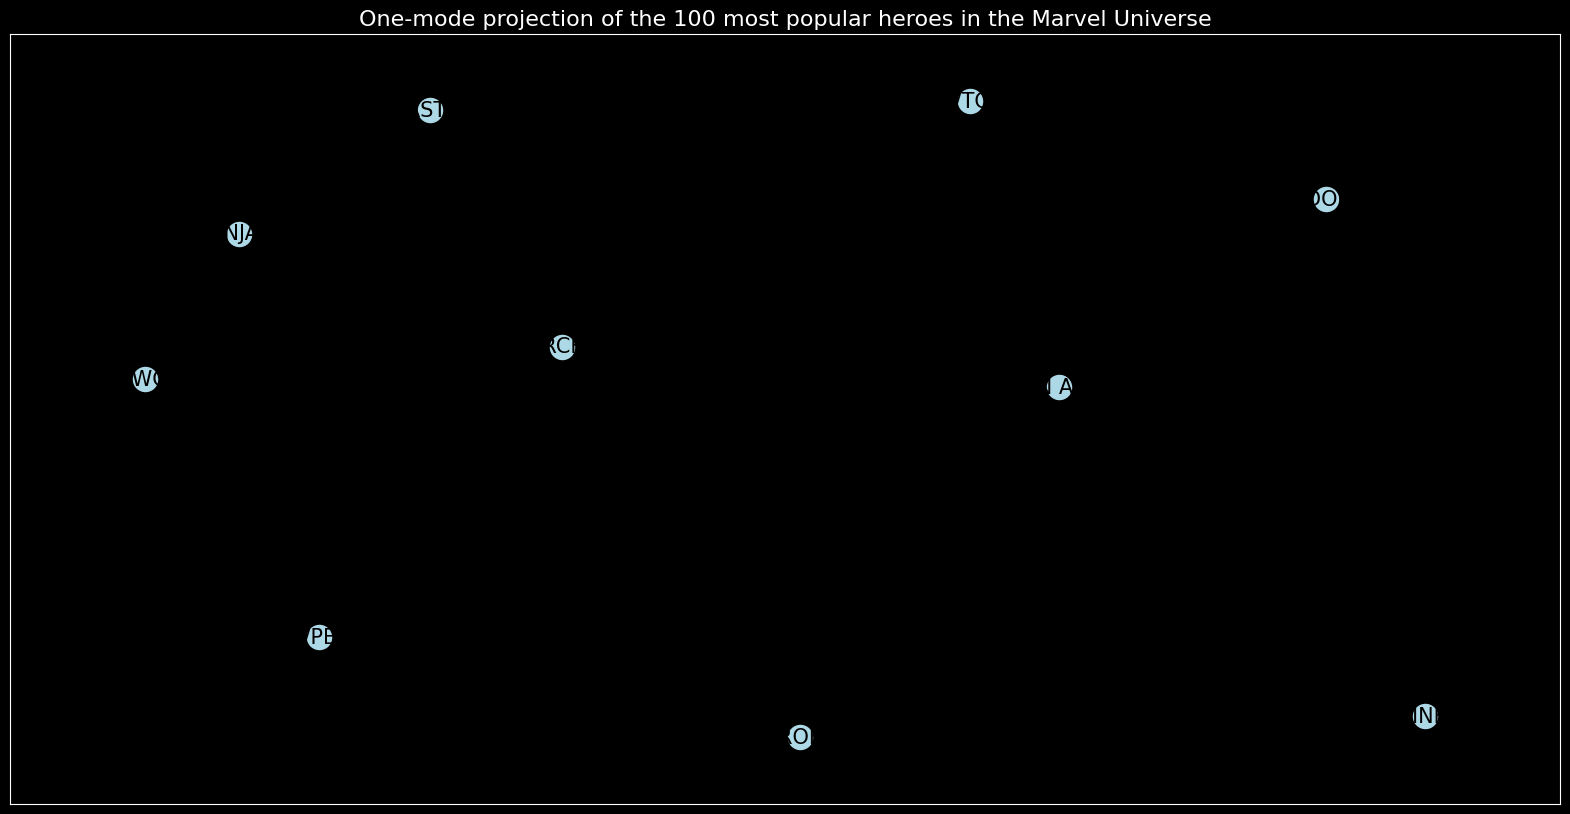

In [63]:
plt.figure(figsize=(20, 10))
plt.title("One-mode projection of the 100 most popular heroes in the Marvel Universe", fontsize=16)
draw_graph_and_color_groups(G_one_mode, layout="spring")

### Communities

wie funktioniert greedy modularity? 
- community.girvan_newman ausprobieren
- Edge Betweenness berechnen
- Edge Betweeness Clustering

In [64]:
communities = community.greedy_modularity_communities(G_one_mode)
len(communities)

1

Bei der Community Detection haben wir uns für die Greedy Modularity Methode entschieden. Diese Methode ist sehr schnell und lieferte 2 verschiedene Communities.

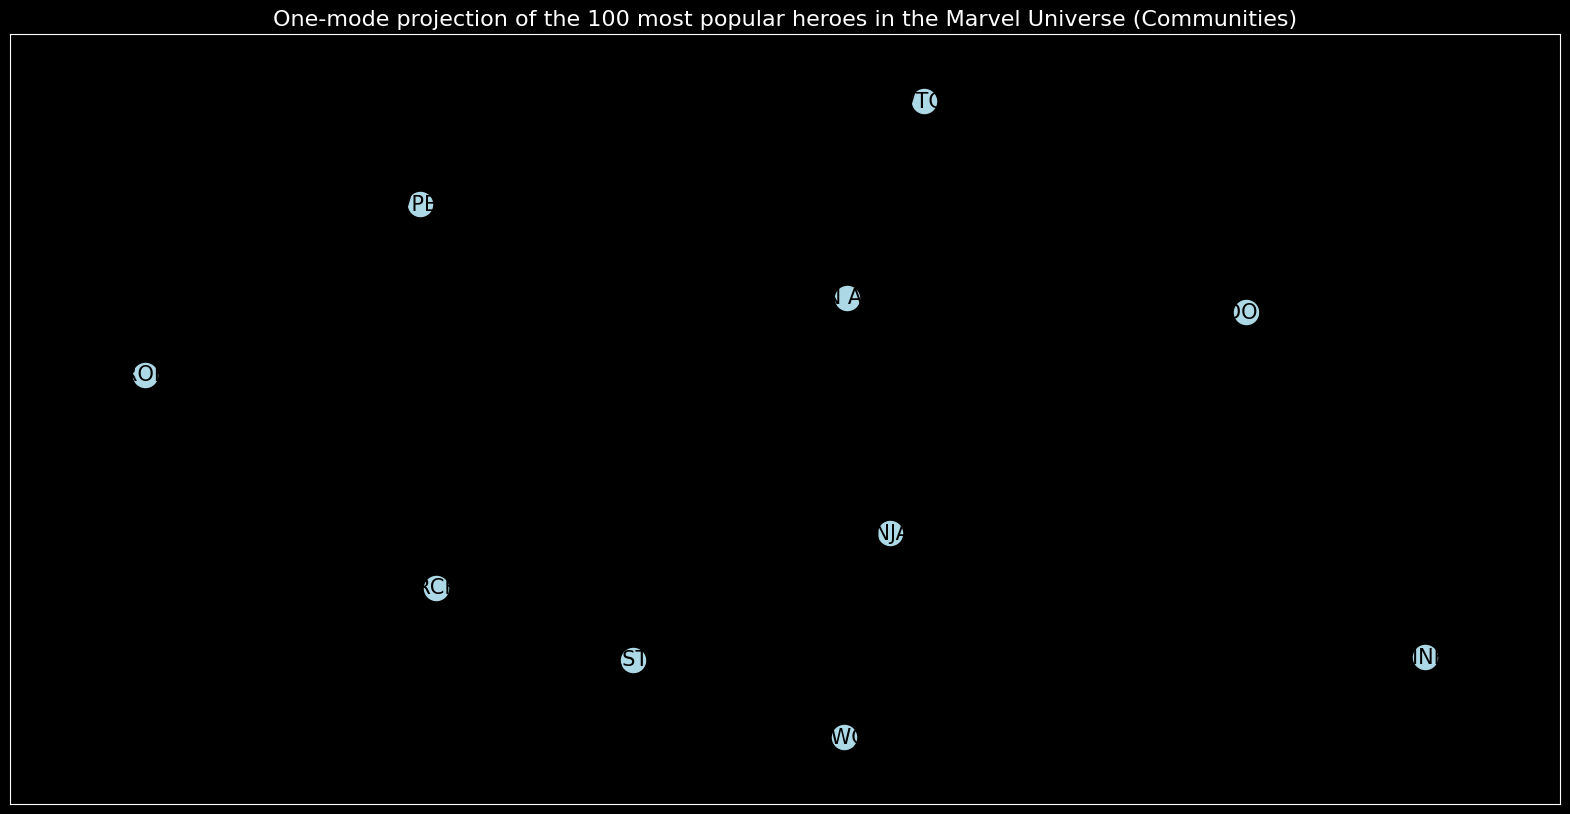

In [65]:
plt.figure(figsize=(20, 10))
plt.title("One-mode projection of the 100 most popular heroes in the Marvel Universe (Communities)", fontsize=16)
draw_graph_and_color_groups(G_one_mode, communities, layout="spring")

## Frage 4 - Identifizierung von Helden mit einem Grad von 1
- Berechne den Grad jedes Helden im Netzwerk.
- Filtere die Liste, um nur die Helden zu behalten, deren Grad gleich 1 ist.
- Diese Liste gibt die Helden, die nur in einem einzigen Comic erscheinen.

In [66]:
# Calculate degree
degrees = {hero: B.degree(hero) for hero in B.nodes()}

# Filter out the heroes with only one comic
heroes_with_one_comic = [hero for hero, deg in degrees.items() if deg == 1]

print("Anzahl Helden im gesamten Datensatz, welche nur in einem einzigen Comic erscheinen:", len(heroes_with_one_comic))
print(heroes_with_one_comic[:5])

Anzahl Helden im gesamten Datensatz, welche nur in einem einzigen Comic erscheinen: 3275
['24-HOUR MAN/EMMANUEL', 'ABBOTT, JACK', 'ABOMINATION | MUTANT', 'ABSORBING MAN | MUTA', 'ACBA']


In [67]:
# Filtern nach Helden mit dem höchsten Grad
top_degree_hero, degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[0]
print(top_degree_hero + " hat den höchsten Grad mit " + str(degree) + " Comics.")

SPIDER-MAN/PETER PARKER hat den höchsten Grad mit 1577 Comics.


# comics als nodes und zentralitäten und so berechnen, communities etc

Netzwerk mit den 100 häufigsten Comics!

In [68]:
# Ermitteln der Top 100 Helden basierend auf der Anzahl der Erscheinungen
top_comics = edges_df['comic'].value_counts().head(100).index

top_edges_df = edges_df[edges_df["comic"].isin(top_comics)]

G = nx.Graph()

# Add nodes with the node attribute "bipartite"
G.add_nodes_from(top_comics, bipartite=0)  # Comics
G.add_nodes_from(set(top_edges_df['hero']), bipartite=1)  # Comics

# Add edges with weights based on the number of shared comics
for comic, df in top_edges_df.groupby('comic'):
    for hero in df['hero']:
        if G.has_edge(comic, hero):
            G[comic][hero]['weight'] += 1
        else:
            G.add_edge(comic, hero, weight=1)

# Create a one-mode projection of the graph where nodes are heroes
G_one_mode_comics = nx.bipartite.weighted_projected_graph(G, list(top_comics))
# and edges represent the number of comics they both appear in

# Extract the weights for the edges and sort them to find the strongest connections
weights = nx.get_edge_attributes(G_one_mode_comics, 'weight')
sorted_weights = sorted(weights.items(), key=lambda item: item[1], reverse=True)

# Output the graph edges with weights and the strongest connections
sorted_weights[:10], list(G_one_mode_comics.edges(data=True))[:10]

([(('IW 3', 'IW 4'), 78),
  (('IW 3', 'IW 2'), 71),
  (('COC 1', 'H2 279'), 64),
  (('IW 4', 'IW 2'), 62),
  (('IW 3', 'IW 1'), 60),
  (('IW 1', 'IW 2'), 58),
  (('IW 1', 'IW 4'), 52),
  (('IW 3', 'MK3 41'), 48),
  (('IW 3', 'FF 368'), 47),
  (('IW 3', 'IW 6'), 47)],
 [('COC 1', 'A 18', {'weight': 23}),
  ('COC 1', 'M/SHSW 12', {'weight': 16}),
  ('COC 1', 'NM 7', {'weight': 4}),
  ('COC 1', 'M/SHSW 11', {'weight': 16}),
  ('COC 1', 'M/SHSW 6', {'weight': 15}),
  ('COC 1', 'H2 277', {'weight': 28}),
  ('COC 1', 'MAXSEC 3', {'weight': 27}),
  ('COC 1', 'M/SHSW 4', {'weight': 16}),
  ('COC 1', 'Q 38', {'weight': 25}),
  ('COC 1', 'X:PRIME', {'weight': 10})])

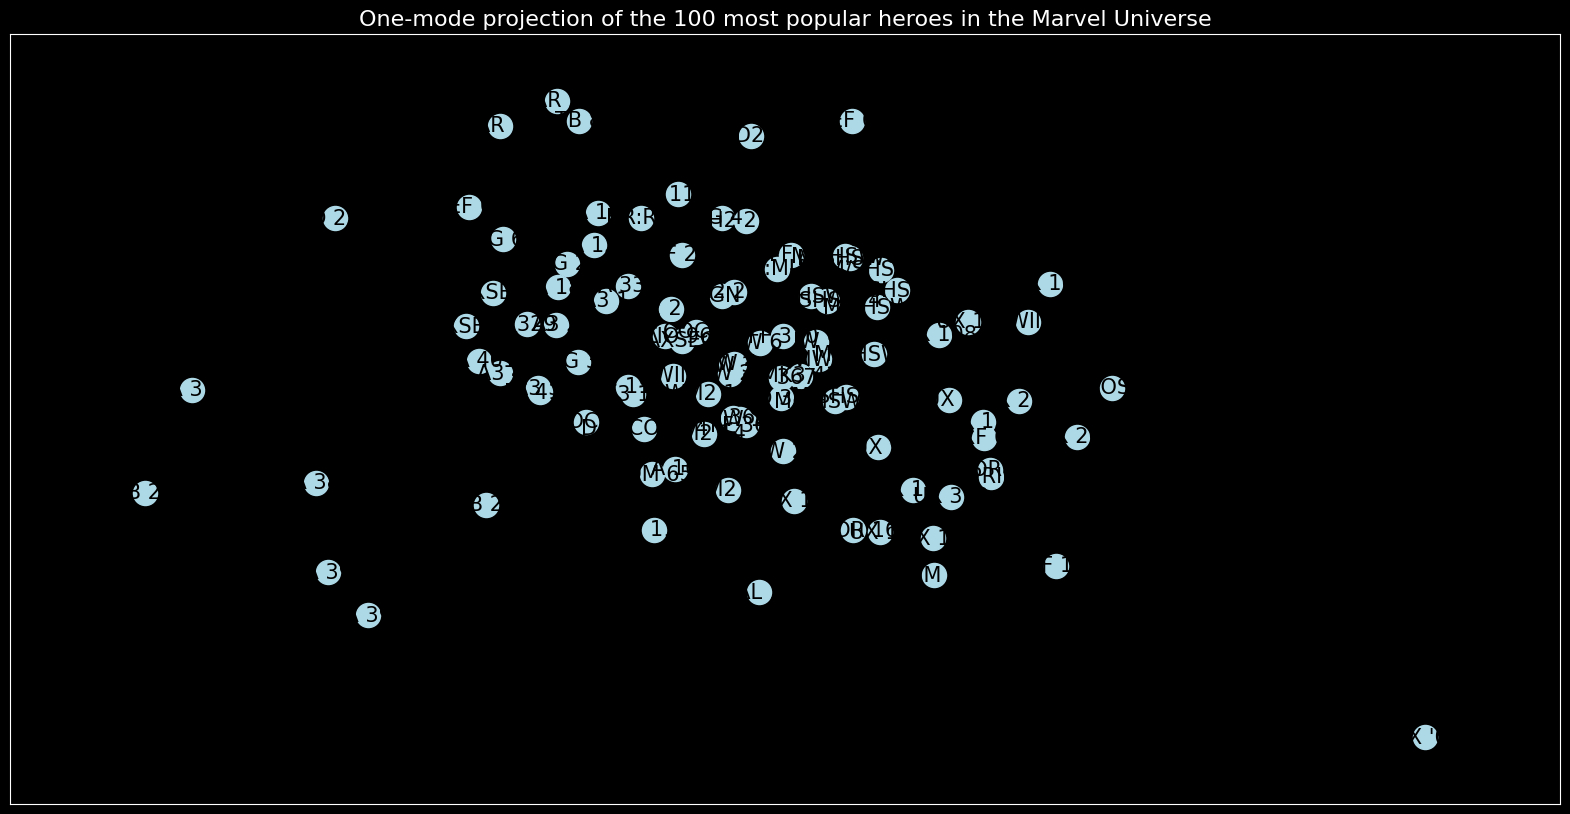

In [69]:
plt.figure(figsize=(20, 10))
plt.title("One-mode projection of the 100 most popular heroes in the Marvel Universe", fontsize=16)
draw_graph_and_color_groups(G_one_mode_comics, layout="spring")

# in welchem comics die meisten superhelden sind (top 100 comics)

In [70]:
# Group by 'comic' and count the number of unique heroes in each comic
df_heros_per_comic = edges_df.groupby('comic')['hero'].nunique().reset_index()

# Rename the columns appropriately
df_heros_per_comic.columns = ['comic', 'hero_count']

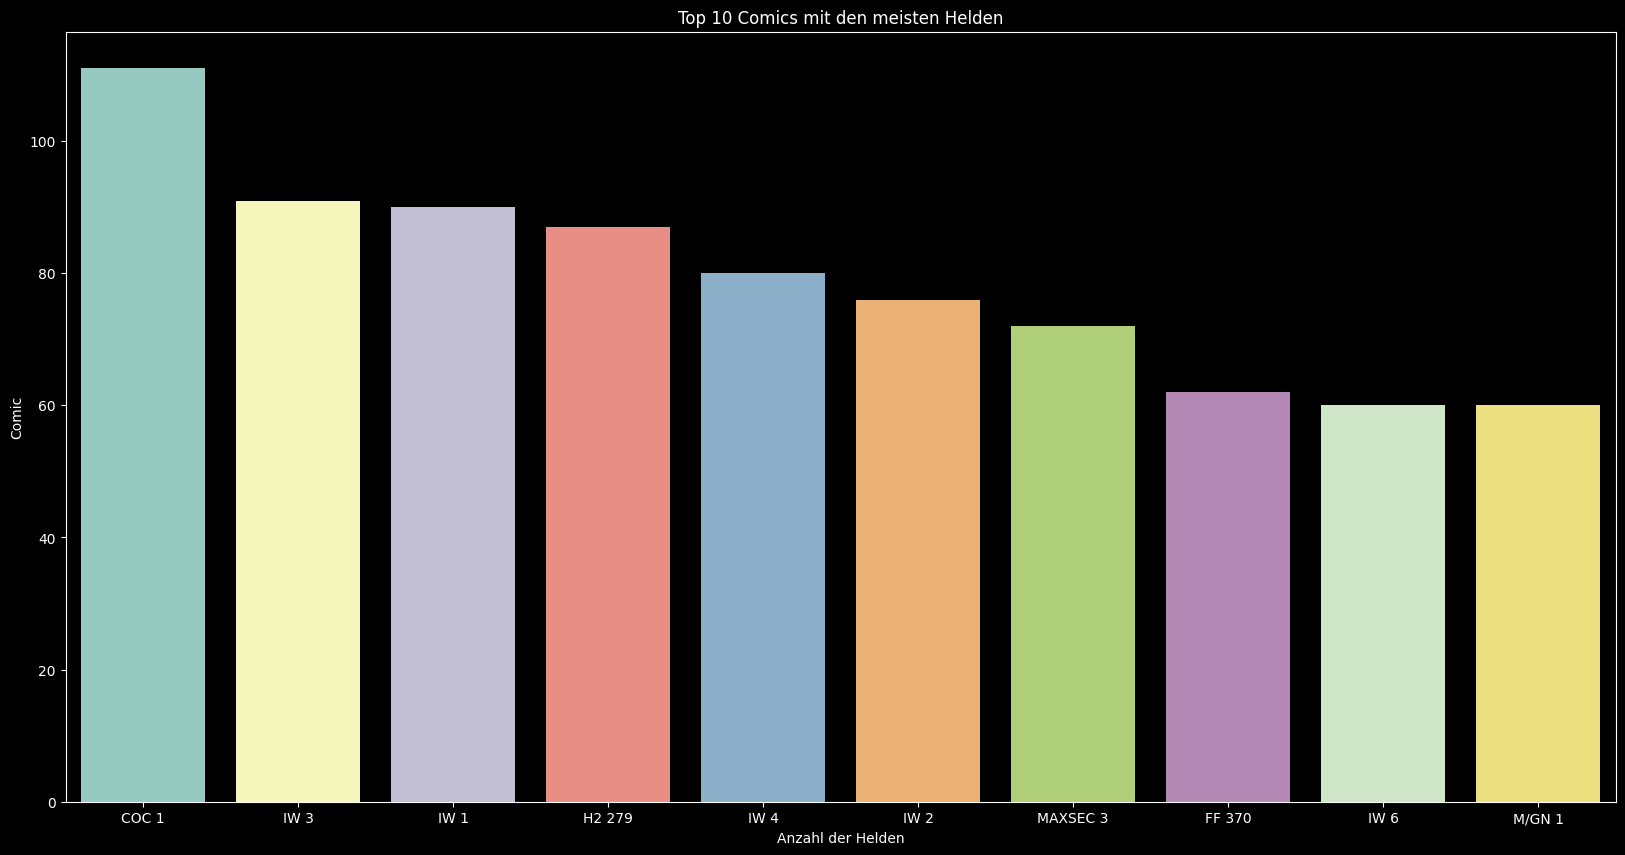

In [71]:
df_heros_per_comic_top_10 = df_heros_per_comic.sort_values(ascending=False, by="hero_count").head(10)


# print a barchart of the top 10 comics with the most heroes
plt.figure(figsize=(20, 10))
sns.barplot(x=df_heros_per_comic_top_10.comic, y=df_heros_per_comic_top_10.hero_count)
plt.title('Top 10 Comics mit den meisten Helden')
plt.xlabel('Anzahl der Helden')
plt.ylabel('Comic')
plt.show()

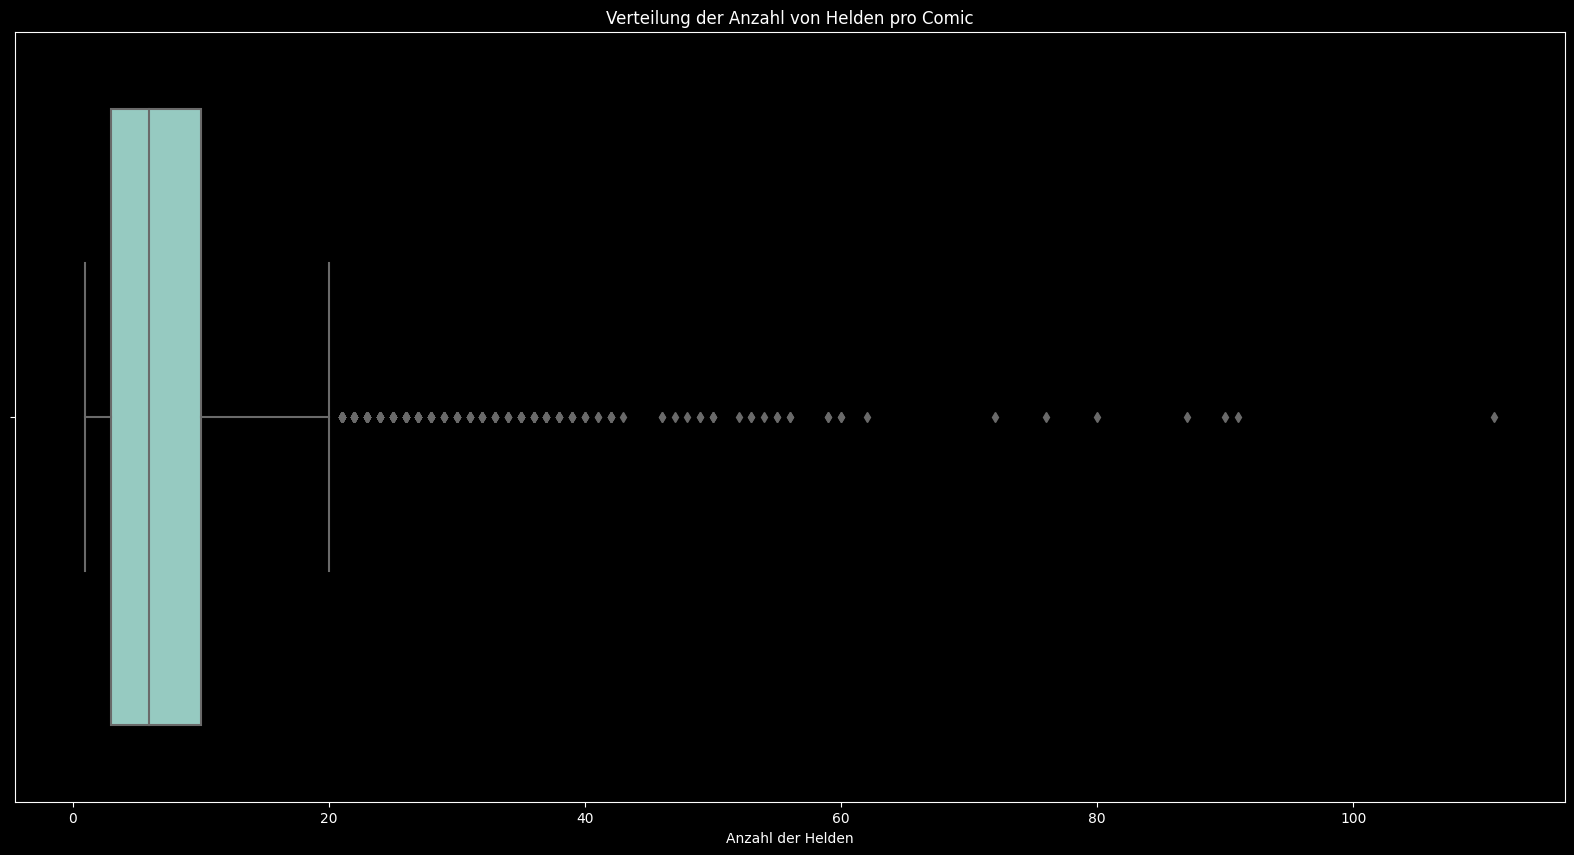

In [72]:
df_heros_per_comic

# plot a boxplot of the number of heroes per comic
plt.figure(figsize=(20, 10))
sns.boxplot(x=df_heros_per_comic.hero_count)
plt.title('Verteilung der Anzahl von Helden pro Comic')
plt.xlabel('Anzahl der Helden')
plt.show()

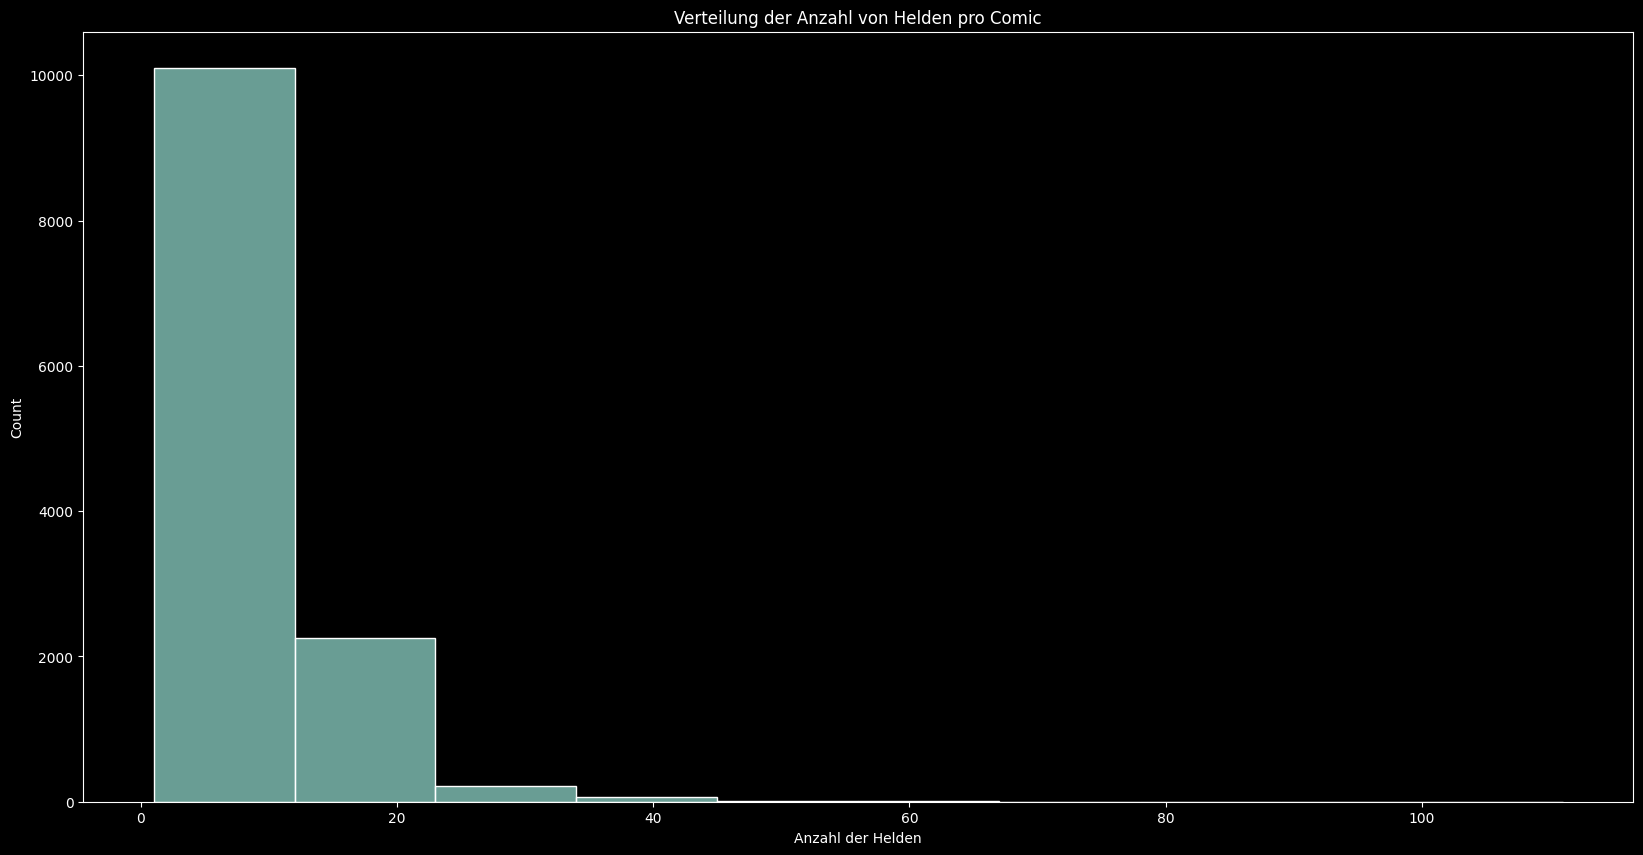

In [73]:
# show the distribution of the number of heroes per comic
plt.figure(figsize=(20, 10))
sns.histplot(df_heros_per_comic.hero_count, bins=10)
plt.title('Verteilung der Anzahl von Helden pro Comic')
plt.xlabel('Anzahl der Helden')
plt.show()

In [78]:
# get only the outliers of the number of heroes per comic

# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = np.percentile(df_heros_per_comic['hero_count'], 25)
Q3 = np.percentile(df_heros_per_comic['hero_count'], 75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = df_heros_per_comic[(df_heros_per_comic.hero_count.values < lower_bound) | (df_heros_per_comic.hero_count.values > upper_bound)]

print(outliers)

         comic  hero_count
3        A '00          23
5        A '98          21
6        A '99          27
7          A 1          27
9         A 10          35
...        ...         ...
12435  XFOR 16          36
12436  XFOR 17          37
12439   XFOR 3          21
12575   XSOS 2          37
12593    XU 23          23

[444 rows x 2 columns]


# comic übereinstimmungen -> fortsetzungen?

In [20]:
edges_df

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [92]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

# Create a pivot table
pivot_table = pd.pivot_table(edges_df, index='comic', columns='hero', aggfunc=len, fill_value=0)

# Convert pivot table to sparse matrix
sparse_matrix = sparse.csr_matrix(pivot_table.values)

# Calculate cosine similarity
cosine_sim = cosine_similarity(sparse_matrix)

# Convert cosine similarity matrix to DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=pivot_table.index, columns=pivot_table.index)

In [94]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
import numpy as np

edges_df_copy = edges_df.copy()

edges_df_copy = edges_df_copy.drop(columns=['hero'])

edges_df_copy['similarity'] = None

# Loop through each row in edges_df_copy
for i, row in edges_df_copy.iterrows():
    # Calculate the mean cosine similarity for the current index
    mean_similarity = cosine_sim_df[cosine_sim_df.index == row['comic']].mean(axis=1).values[0]
    
    # Assign this value to the 'similarity' column of edges_df_copy
    edges_df_copy.at[i, 'similarity'] = mean_similarity

edges_df_copy.drop_duplicates(inplace=True)


In [95]:
edges_df_copy.groupby('comic').mean().sort_values(by='similarity', ascending=False).head(100)

,similarity
comic,
H2 153,0.087453
M/TIO 7,0.086474
ST 156,0.085685
H 11,0.084126
UTSM '97,0.083942
...,...
A2 10,0.061425
ROM 23,0.061402
IM2 6,0.061175


In [96]:
cosine_sim_df.replace(0, np.nan, inplace=True)

In [97]:
cosine_sim_df.groupby('comic').mean().sort_values(by='similarity', ascending=False).head(100)

KeyError: 'similarity'

In [79]:
# Initialize an empty dictionary
non_nan_columns_per_row = {}

# Iterate over each row in the DataFrame
for index, row in cosine_sim_df.iterrows():
    # Initialize a list for this row index
    non_nan_columns_per_row[index] = []
    # For each row, iterate over each column
    for col in cosine_sim_df.columns:
        # Check if the value in the column for this row is not NaN and greater than 0.9
        if not pd.isna(row[col]) and row[col] > 0.5 and col != index:
            # Append the column name to the list for this row index
            non_nan_columns_per_row[index].append(col)



In [ ]:
df_heros.head(10)

In [ ]:
edges_df.head(10)

In [ ]:
nodes_df.head(10)

In [27]:
import networkx as nx

G = nx.Graph()

# Beispieldaten für das Netzwerk
# Hier fügen Sie Ihre Daten ein: G.add_edge("Comic1", "CharakterA"), etc.
G.add_nodes_from(nodes_df[nodes_df['type'] == 'hero']['node'], bipartite=0, type='hero')
G.add_nodes_from(nodes_df[nodes_df['type'] == 'comic']['node'], bipartite=1, type='comic')
G.add_edges_from(edges_df.values)

# Liste aller Comics im Netzwerk
comics = [node for node in G.nodes() if "Comic" in node]

# Wörterbuch, um die nächstgelegenen Comics für jeden Comic zu speichern
naechstgelegene_comics = {}

for comic in comics:
    distanzen = {}
    for anderer_comic in comics:
        if comic != anderer_comic:
            try:
                # Kürzester Pfad zwischen den Comics
                pfad = nx.shortest_path(G, source=comic, target=anderer_comic)
                distanzen[anderer_comic] = len(pfad) - 1
            except nx.NetworkXNoPath:
                # Wenn kein Pfad existiert, ignorieren oder einen hohen Wert setzen
                pass

    # Sortieren der Comics nach ihrer Distanz
    sortierte_comics = sorted(distanzen.items(), key=lambda x: x[1])
    naechstgelegene_comics[comic] = sortierte_comics

# Ausgabe der Ergebnisse
for comic, nahe_comics in naechstgelegene_comics.items():
    print(f"Nächstgelegene Comics für {comic}: {nahe_comics[:5]}")  # Die ersten 5 nächstgelegenen Comics


# Welche helden kommen in allen COC comics vor?

Analyzing a network of comics and heroes can reveal fascinating insights into the structure and dynamics of the comic universe. Here are several interesting questions you could explore through network analysis:

Who are the most central heroes?

Investigate which heroes are the most central in the network using metrics like degree centrality, betweenness centrality, and eigenvector centrality. This can highlight key characters who are pivotal to the comic universe.
What are the most influential comics?

Determine which comics have the most significant impact on the network. This can be assessed using similar centrality measures or by identifying comics that introduced significant characters or story arcs.
How are heroes interconnected?

Analyze the connections between heroes to see how they are related. Are there groups of heroes that frequently appear together? This could indicate alliances, teams, or common story themes.
Are there community structures within the network?

Use community detection algorithms to identify clusters within the network. These could represent different superhero teams, universes, or genres within the comics.
How has the network evolved over time?

If you have temporal data (like publication dates), you can analyze how the network has grown and changed. Which heroes or comics were pivotal at different times?
What are the characteristics of the most interconnected comics or heroes?

Examine the attributes of the most interconnected nodes. Do they share certain characteristics, like genre, era, or creative team?
Which heroes are similar based on their comic appearances?

Calculate similarity measures (like Jaccard or cosine similarity) to find heroes that appear in similar sets of comics.
How resilient is the network?

Test the network's resilience by simulating the removal of key heroes or comics. How does this affect the overall structure?
What role do minor characters play in the network?

Analyze the role of less central characters. Do they bridge different communities or serve unique roles within the network?
Are there patterns in hero-team formations?

Investigate the formation of teams or groups within the network. Are there recurring patterns in how teams are formed?
What is the shortest path between two randomly chosen heroes?

This can reveal interesting connections and how heroes are indirectly linked through other characters or comics.
Which comics or heroes serve as bridges between different communities?

Identify nodes that act as connectors between otherwise separate parts of the network, indicating crossover events or influential characters.
What is the distribution of heroes per comic?

Analyze how many heroes typically appear in a comic. Are there comics that consistently feature large ensembles?
What are the outlier comics or heroes?

Identify any nodes that don't follow the general patterns of the network, which could be either very isolated or unusually well-connected.
Each of these questions can be addressed with specific network analysis techniques and metrics, and they can provide deep insights into both the narrative and structural aspects of the comic universe.

# Link Prediction -> welche helden könnten in einem comic zusammen auftreten?